In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib as mpl

# Linear least-squares in a linear-Gaussian mixture model

In this assignment, we will study sources of disparate accuracy using a linear-Gaussian mixture model.
Suppose that sub-population $a$ follows distribution $\mathcal D_a$ described as:
$$ x\sim \mathcal N(\mu_a, \Sigma_a),\quad v\sim \mathcal N(0, \sigma^2_a),\quad y=\theta_a^\top x + v $$
Also assume that sub-population $a$ makes up $p_a$ proportion of the population, where $\sum_{a} p_a$ = 1.

Derive an expression for the linear least-squares predictor:
$$ \theta_\star = \arg\min_{\theta\in\mathbb R^d} \mathbb E_{x,y\sim\mathcal D}[(\theta^\top x-y)^2] =\arg\min_{\theta\in\mathbb R^d} \mathbb E_{a}\left[\mathbb E_{x,y\sim\mathcal D_a}[(\theta^\top x-y)^2]\right]$$
You answer should be in terms of $\mu_a$, $\Sigma_a$, $\sigma^2_a$, $\theta_a$, and $p_a$.
Also derive an expression for the optimal risk $\mathcal R(\theta_\star)$.
Implement both in the function below.

In [2]:
def linear_least_squares(mus, Sigmas, sigmas, thetas, proportions):
    # theta star calc
    num_subgroups, d = thetas.shape
    s1, s2 = np.zeros(d), np.zeros(d)
    for i in range(num_subgroups):
        temp = proportions[i] * (Sigmas[i] + np.dot(mus[i].T, mus[i]))
        s1 = s1 + temp
        s2 = s2 + (temp @ thetas[i])
    theta_star = np.linalg.inv(s1) @ s2

    # risk calc
    risk_star = 0
    risk_subgroups = np.zeros(num_subgroups)
    for i in range(num_subgroups):
        risk_subgroups[i] = (theta_star - thetas[i]).T @ (Sigmas[i] + np.dot(mus[i].T, mus[i])) @ (theta_star - thetas[i]) + sigmas[i]
        temp = proportions[i] * risk_subgroups[i]
        risk_star = risk_star + temp
    
    return theta_star, risk_star, risk_subgroups

### Disparate accuracy 

Now, instantiate some example distribution with at least two sub-populations. Compute the risk minimizer $\theta_\star$ using the function above. Compare the overall risk to the risk within each sub-population.

In [23]:
# instantiating values
def init_dist(d):
  proportions = [.2, .8]
  mus = np.random.uniform(-5, 5, size=(2, d, 1))
  Sig = np.random.uniform(-1, 1, size=(2, d, d))
  Sigmas = Sig.transpose((0, 2, 1)) @ Sig
  sigmas = np.random.uniform(-1, 1, size=(2))
  thetas = np.random.uniform(-1, 1, size=(2, d))
  return proportions, mus, Sigmas, sigmas, thetas

In [24]:
d = 5
proportions, mus, Sigmas, sigmas, thetas = init_dist(d)
theta_star, risk_star, risk_subgroups = linear_least_squares(mus, Sigmas, sigmas, thetas, proportions)
print(f'Overall Risk: {risk_star}')
print(f'\tSubgroup 1 Risk: {risk_subgroups[0]}')
print(f'\tSubgroup 2 Risk: {risk_subgroups[1]}')

Overall Risk: 37.760946566749716
	Subgroup 1 Risk: 172.1652646600273
	Subgroup 2 Risk: 4.159867043430324


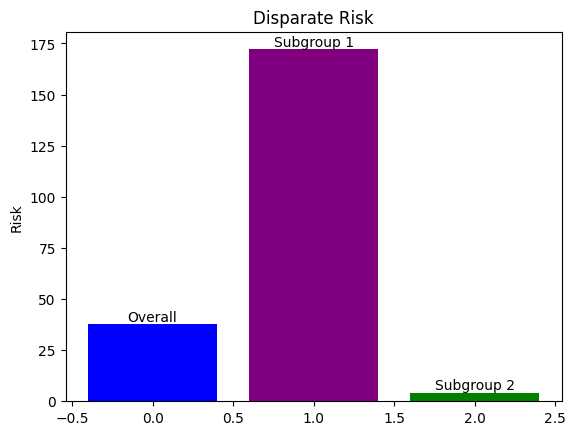

In [25]:
barplot = plt.bar(range(3), [risk_star, risk_subgroups[0], risk_subgroups[1]], color=['blue', 'purple', 'green'])
plt.bar_label(barplot, ['Overall', 'Subgroup 1', 'Subgroup 2'])
plt.title('Disparate Risk')
plt.ylabel('Risk')
plt.savefig('graphics/task2risk.png')

### Disparate prediction errors

For this task, you will likely want to refer to the [plotting code from lecture 2](https://github.com/ml-feedback-sys/materials-f23/blob/main/notebooks/Non-Discrimination%20Criteria%20Plots.ipynb)

We will now visualize the distribution of true and predicted labels within each subgroup. Implement functions for the probability density functions of:
- the distribution of predictions within each sub-population: $\hat y \mid a$
- the distribution of predictions conditioned on true labels within each sub-population: $\hat y \mid y, a$
- the distribution of true labels conditioned on predictions within each sub-population: $y \mid \hat y, a$

These function should take as input two or three arguments, corresponding to $y$, $\hat y$, and $a$, and return a scalar value representing the probability density.

Use these functions to generate plots similar to the ones presented in lecture 2. You should have a total of three plots per sub-population.

In [26]:
def calc_dist(a, mus, Sigmas, sigmas, thetas, theta_star):
  mu_yhat = theta_star.T @ mus[a]
  var_yhat = theta_star.T @ Sigmas[a] @ theta_star

  mu_y = thetas[a].T @ mus[a]
  var_y = thetas[a].T @ Sigmas[a] @ thetas[a] + sigmas[a]**2

  mu_vec = np.array([mu_y, mu_yhat]).ravel()

  cov = thetas[a].T @ Sigmas[a] @ theta_star

  cov_mat = np.array([[var_y, cov],[cov, var_yhat]])

  mu_yyhat = lambda yhat: (mu_y + (cov / var_yhat) * (yhat - mu_yhat)).ravel()
  var_yyhat = (var_y - (cov**2 / var_yhat)).ravel()

  mu_yhaty = lambda y: (mu_yhat + (cov / var_y) + (y - mu_y)).ravel()
  var_yhaty = (var_yhat - (cov**2 / var_y)).ravel()
  
  return mu_vec, cov_mat, mu_yyhat, var_yyhat, mu_yhaty, var_yhaty

In [36]:
pdf_joint = lambda y_vec, mu_vec, cov_mat: multivariate_normal.pdf(y_vec, mean=mu_vec, cov=cov_mat)
pdf_cond = lambda y1, y2, mu, var: multivariate_normal.pdf(y1, mean=mu(y2), cov=var)

def probability_density(a, theta_star, mus, Sigmas, sigmas, thetas, n):
  
  fig, axes = plt.subplots(a, 3, figsize=(6 * 3, 12), sharex=False, sharey=False)

  for i in range(a):
    mu_vec, cov_mat, mu_yyhat, var_yyhat, mu_yhaty, var_yhaty = calc_dist(i, mus, Sigmas, sigmas, thetas, theta_star)

    ylin = np.linspace(-10, 10, 100)
    yhatlin = np.linspace(-10, 10, 100)

    y, yhat  = np.meshgrid(ylin, yhatlin)

    # joint
    ret = axes[i,0].contourf(y, yhat, pdf_joint(np.dstack((y, yhat)), mu_vec, cov_mat), cmap='inferno')
    axes[i,0].set_title("joint distribution")
    axes[i,0].set_xlabel("true label", fontsize=8)
    axes[i,0].set_ylabel("predicted label", fontsize=8)
    fig.colorbar(ret)

    # conditional (true|pred)
    dist = np.vstack([pdf_cond(ylin[:,np.newaxis], yhati, mu_yyhat, var_yyhat) for yhati in yhatlin])
    ret = axes[i,1].contourf(y, yhat, dist, cmap='inferno')
    axes[i,1].set_title("conditional distribution: true | pred")
    axes[i,1].set_xlabel("true label", fontsize=8)
    axes[i,1].set_ylabel("predicted label", fontsize=8)
    fig.colorbar(ret)

    # condtional (pred|true)
    dist = np.vstack([pdf_cond(yhatlin[:,np.newaxis], yi, mu_yhaty, var_yhaty) for yi in ylin])
    ret = axes[i,2].contourf(yhat, y, dist, cmap='inferno')
    axes[i,2].set_title("conditional distribution: pred | true")
    axes[i,2].set_xlabel("true label", fontsize=16)
    axes[i,2].set_ylabel("predicted label", fontsize=16)
    fig.colorbar(ret)

  plt.savefig(f'graphics/heatmaps_{n}.png')

# probability_density(len(proportions), theta_star, mus, Sigmas, sigmas, thetas, 0)

# Task 3
### Disparate prediction deep dive

In [37]:
d=5

In [59]:
# vary proportions
mus = np.random.uniform(-5, 5, size=(2, d, 1))
Sig = np.random.uniform(-1, 1, size=(2, d, d))
Sigmas = Sig.transpose((0, 2, 1)) @ Sig
sigmas = np.random.uniform(-1, 1, size=(2))
thetas = np.random.uniform(-1, 1, size=(2, d))

Proportions: [0.1, 0.9]
Overall Risk: 5.4405824139790875
	Subgroup 1 Risk: 51.4880642308413
	Subgroup 2 Risk: 0.3241955454388403


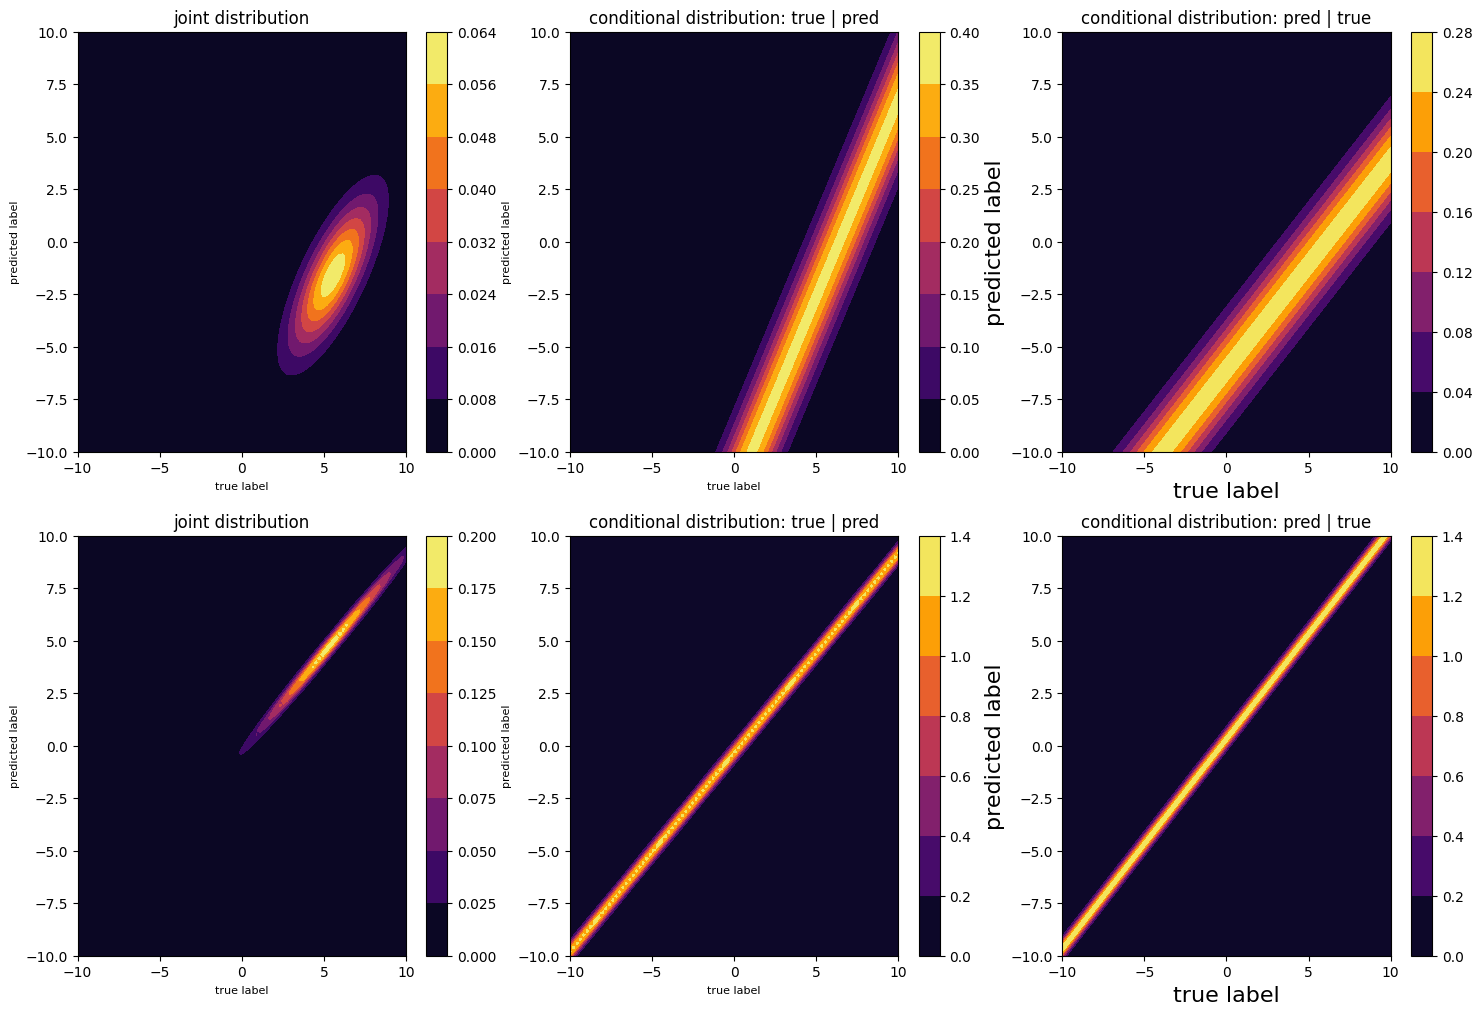

In [60]:
proportions = [0.1, 0.9]
theta_star, risk_star, risk_subgroups = linear_least_squares(mus, Sigmas, sigmas, thetas, proportions)
print(f'Proportions: {proportions}')
print(f'Overall Risk: {risk_star}')
print(f'\tSubgroup 1 Risk: {risk_subgroups[0]}')
print(f'\tSubgroup 2 Risk: {risk_subgroups[1]}')
probability_density(len(proportions), theta_star, mus, Sigmas, sigmas, thetas, 'prop1')

Proportions: [0.3, 0.7]
Overall Risk: 13.433205209951291
	Subgroup 1 Risk: 33.375183487232434
	Subgroup 2 Risk: 4.886643091116516


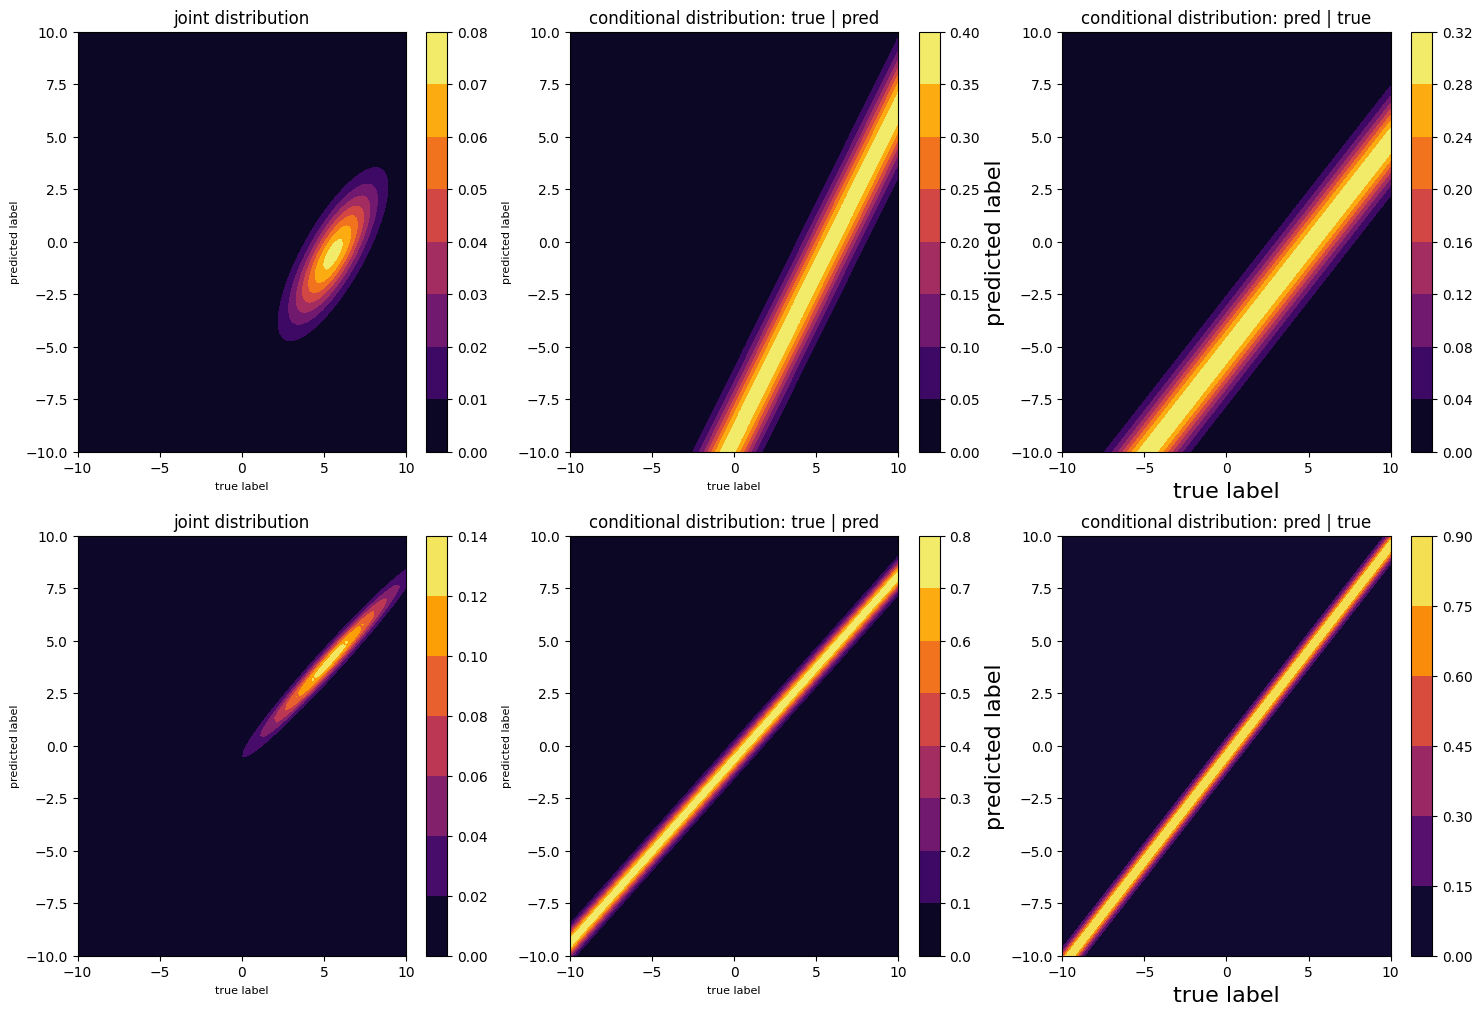

In [61]:
proportions = [0.3, 0.7]
theta_star, risk_star, risk_subgroups = linear_least_squares(mus, Sigmas, sigmas, thetas, proportions)
print(f'Proportions: {proportions}')
print(f'Overall Risk: {risk_star}')
print(f'\tSubgroup 1 Risk: {risk_subgroups[0]}')
print(f'\tSubgroup 2 Risk: {risk_subgroups[1]}')
probability_density(len(proportions), theta_star, mus, Sigmas, sigmas, thetas, 'prop3')

Proportions: [0.5, 0.5]
Overall Risk: 16.68927417663919
	Subgroup 1 Risk: 18.51206407209948
	Subgroup 2 Risk: 14.8664842811789


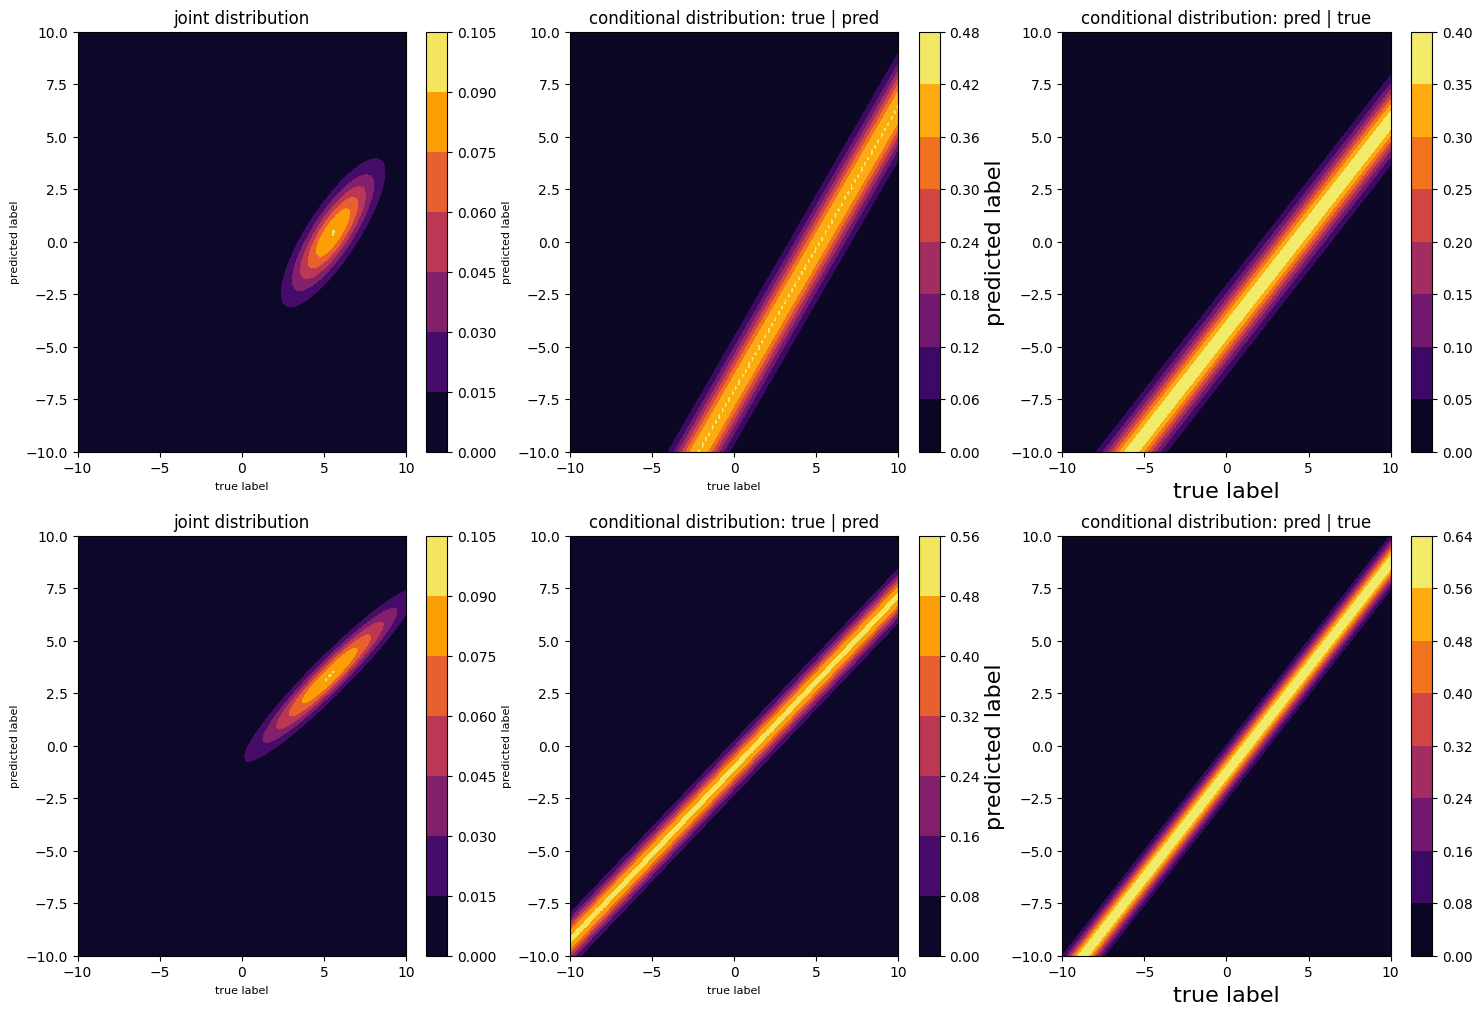

In [62]:
proportions = [0.5, 0.5]
theta_star, risk_star, risk_subgroups = linear_least_squares(mus, Sigmas, sigmas, thetas, proportions)
print(f'Proportions: {proportions}')
print(f'Overall Risk: {risk_star}')
print(f'\tSubgroup 1 Risk: {risk_subgroups[0]}')
print(f'\tSubgroup 2 Risk: {risk_subgroups[1]}')
probability_density(len(proportions), theta_star, mus, Sigmas, sigmas, thetas, 'prop5')

In [71]:
# vary mus
proportions = [0.5, 0.5]
mus = np.random.uniform(-5, 5, size=(2, d, 1))
Sig = np.random.uniform(-1, 1, size=(2, d, d))
Sigmas = Sig.transpose((0, 2, 1)) @ Sig
sigmas = np.random.uniform(-1, 1, size=(2))
thetas = np.random.uniform(-1, 1, size=(2, d))

mus: [[[ 3.4592824 ]
  [-3.86498697]
  [ 3.50231807]
  [-3.87543893]
  [ 1.45465403]]

 [[-0.39998737]
  [-1.63298893]
  [-3.47654704]
  [ 0.03465358]
  [ 0.90450727]]]
Overall Risk: 16.71427270419578
	Subgroup 1 Risk: 6.949251322763003
	Subgroup 2 Risk: 26.479294085628556


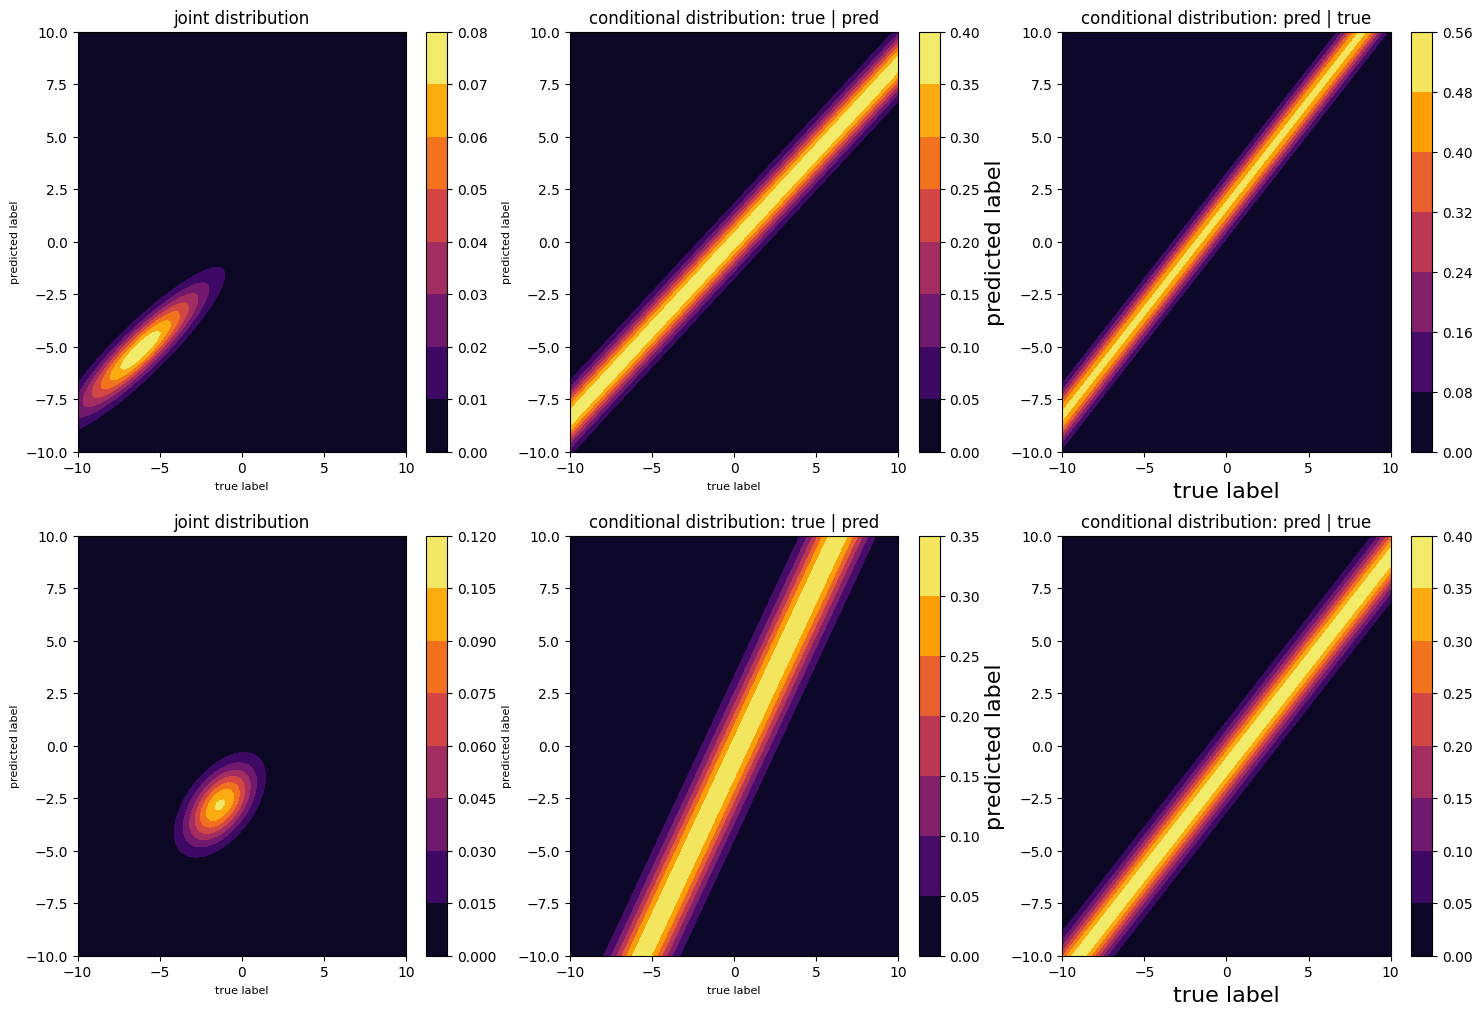

In [72]:
mus = np.random.uniform(-5, 5, size=(2, d, 1))
theta_star, risk_star, risk_subgroups = linear_least_squares(mus, Sigmas, sigmas, thetas, proportions)
print(f'mus: {mus}')
print(f'Overall Risk: {risk_star}')
print(f'\tSubgroup 1 Risk: {risk_subgroups[0]}')
print(f'\tSubgroup 2 Risk: {risk_subgroups[1]}')
probability_density(len(proportions), theta_star, mus, Sigmas, sigmas, thetas, 'mu')

mus: [[[ 6.9185648 ]
  [-7.72997394]
  [ 7.00463615]
  [-7.75087786]
  [ 2.90930806]]

 [[-0.79997475]
  [-3.26597785]
  [-6.95309409]
  [ 0.06930715]
  [ 1.80901453]]]
Overall Risk: 64.54892625604465
	Subgroup 1 Risk: 27.84220629539808
	Subgroup 2 Risk: 101.25564621669123


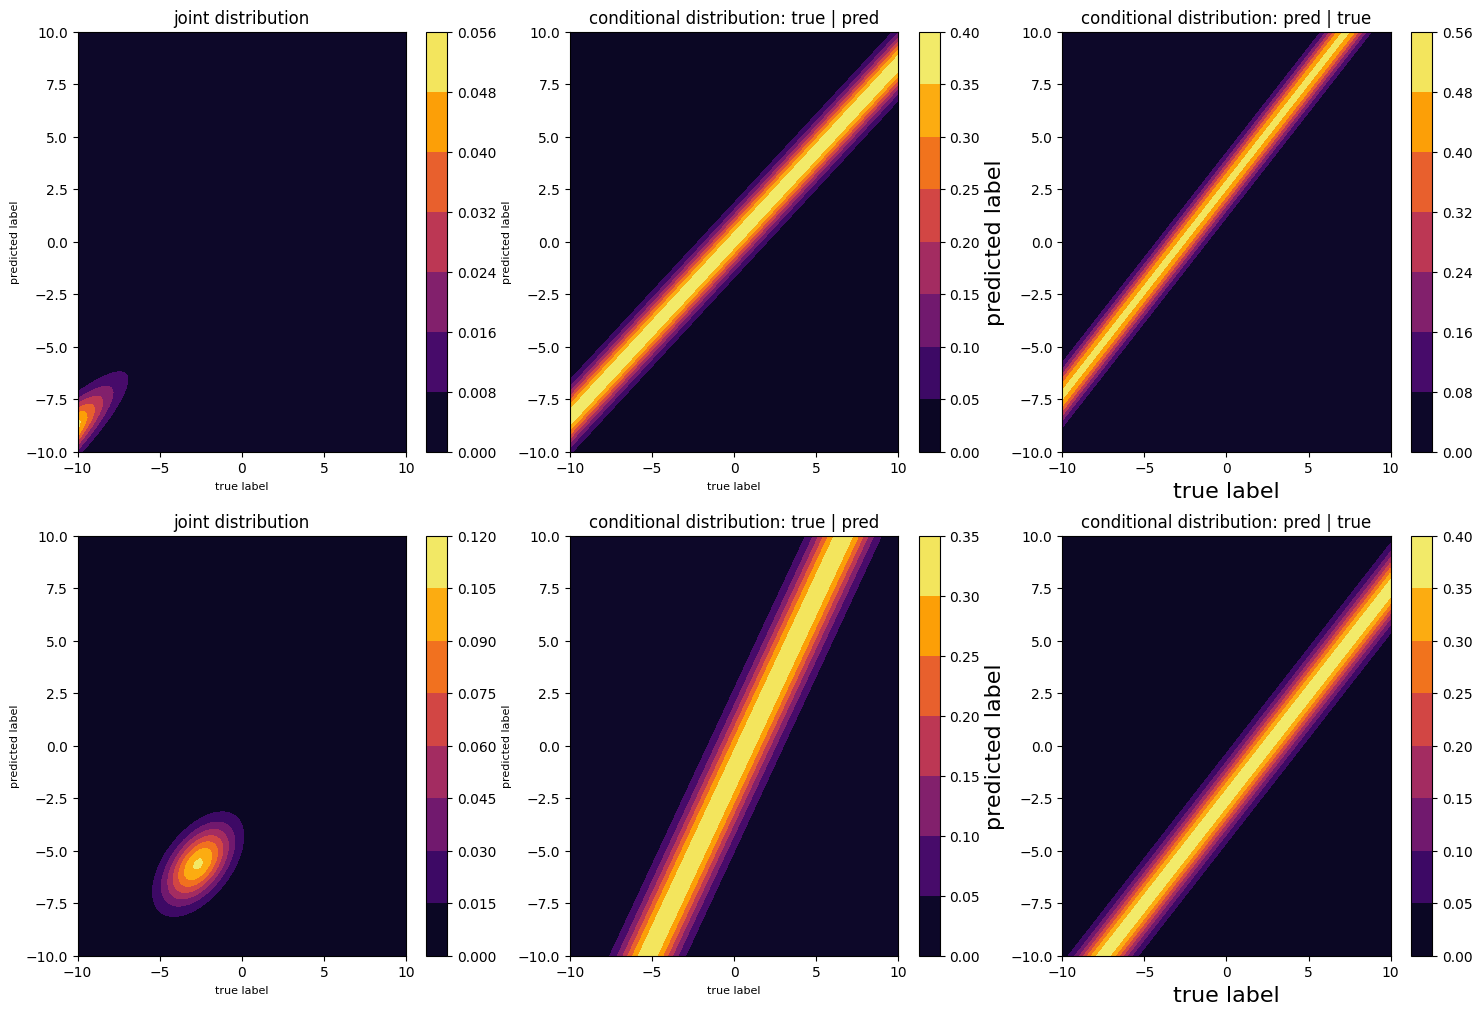

In [73]:
mus = mus *2
theta_star, risk_star, risk_subgroups = linear_least_squares(mus, Sigmas, sigmas, thetas, proportions)
print(f'mus: {mus}')
print(f'Overall Risk: {risk_star}')
print(f'\tSubgroup 1 Risk: {risk_subgroups[0]}')
print(f'\tSubgroup 2 Risk: {risk_subgroups[1]}')
probability_density(len(proportions), theta_star, mus, Sigmas, sigmas, thetas, 'mu2')

mus: [[[ 2.30618827]
  [-2.57665798]
  [ 2.33487872]
  [-2.58362595]
  [ 0.96976935]]

 [[-0.26665825]
  [-1.08865928]
  [-2.31769803]
  [ 0.02310238]
  [ 0.60300484]]]
Overall Risk: 7.855332466124651
	Subgroup 1 Risk: 3.080070916779881
	Subgroup 2 Risk: 12.63059401546942


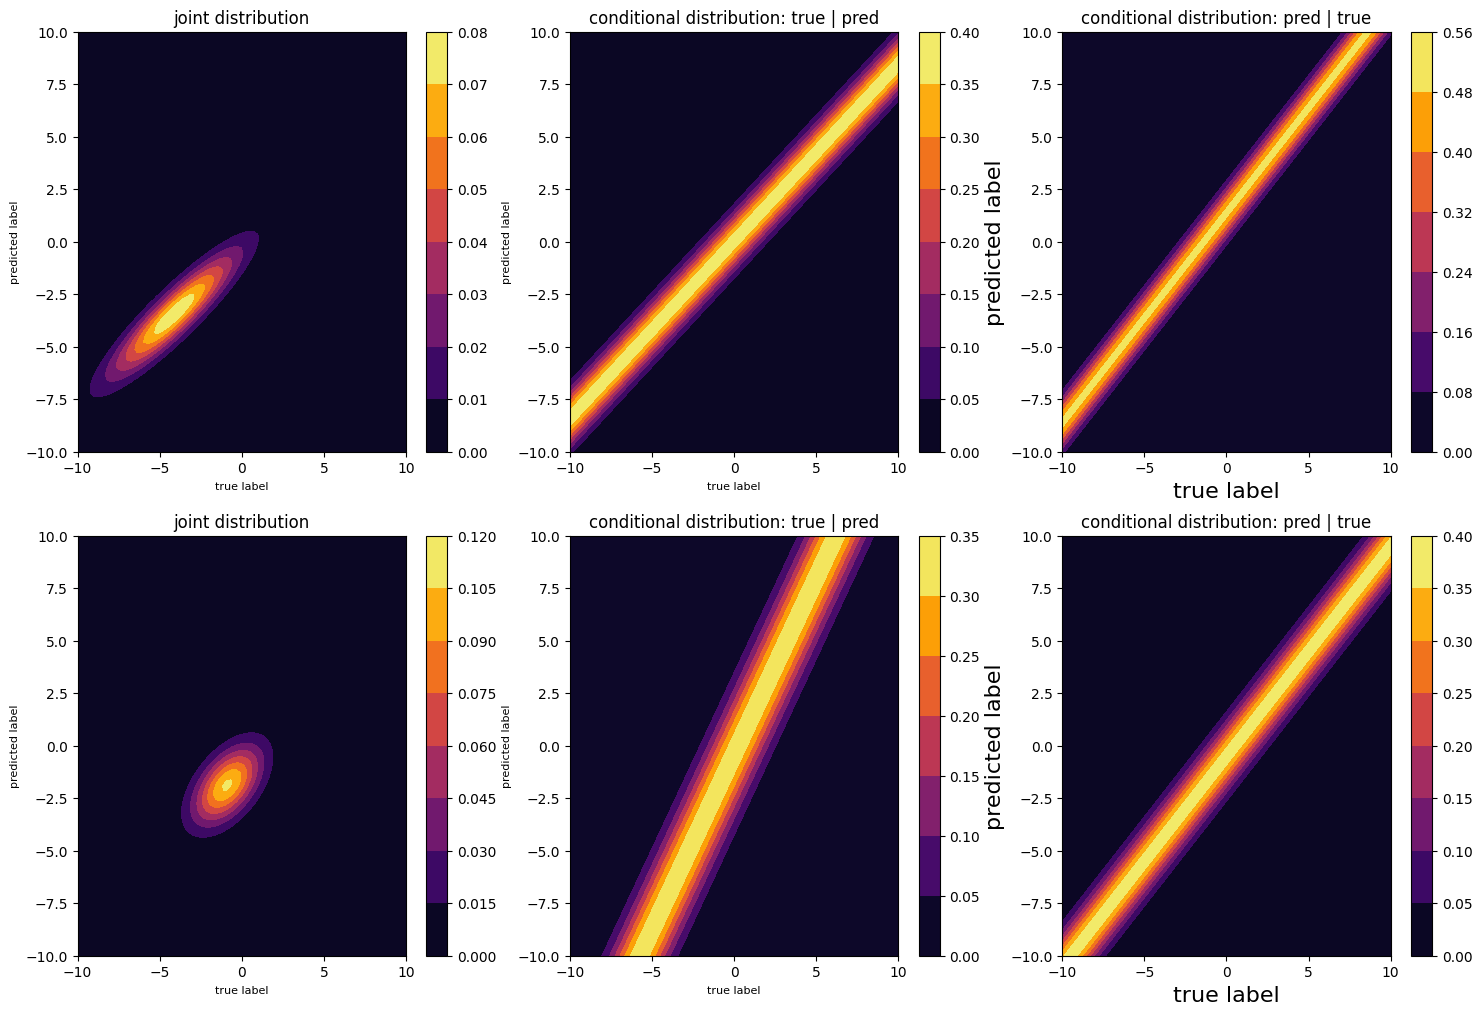

In [74]:
mus = mus / 3
theta_star, risk_star, risk_subgroups = linear_least_squares(mus, Sigmas, sigmas, thetas, proportions)
print(f'mus: {mus}')
print(f'Overall Risk: {risk_star}')
print(f'\tSubgroup 1 Risk: {risk_subgroups[0]}')
print(f'\tSubgroup 2 Risk: {risk_subgroups[1]}')
probability_density(len(proportions), theta_star, mus, Sigmas, sigmas, thetas, 'mudiv3')

In [81]:
risks = []
xs = []
for i in range(1, 10):
  new_mus = mus * i
  theta_star, risk_star, risk_subgroups = linear_least_squares(new_mus, Sigmas, sigmas, thetas, proportions)
  risks.append(risk_star)
  xs.append(i)
  new_mus = mus / i
  theta_star, risk_star, risk_subgroups = linear_least_squares(new_mus, Sigmas, sigmas, thetas, proportions)
  risks.insert(0, risk_star)
  xs.insert(0, 1/i)

Text(0.5, 1.0, 'Mu Modifier vs Risk')

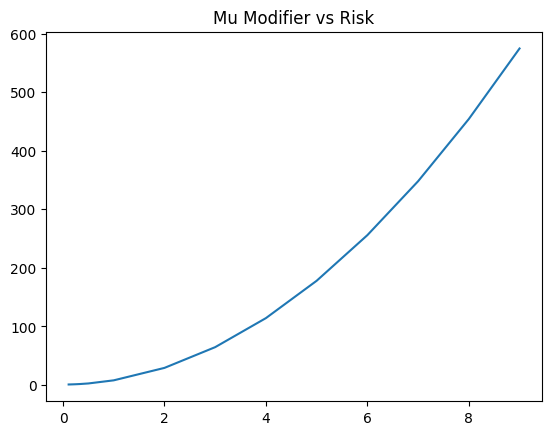

In [83]:
plt.plot(xs, risks)
plt.title('Mu Modifier vs Risk')